# Predicting "protein-protein interactions" with neural networks

# Part 2: building the network

This is the second part of the post. For part one, please refer to 
[this post](/posts/protein_protein_interaction_p1/).

After we have all the datasets sorted out, the next step in to build the
network. The design of the network is really simple. I am using one CNN to
process one sequence, and then concatenate the two networks together and output
the classification results with a DNN.

### Codes

To make sure we run the model on the right device, we first determine the best
device to use for different platforms.

In [12]:
if torch.cuda.is_available():
    # with Nvidia GPU
    device = "cuda"
elif torch.has_mps:
    # on Apple Silicon
    device = "mps"
else:
    # on CPU
    device = "cpu"
device = torch.device(device)

Next, let us build the network. I will use 1D CCN here, use the sequences as the
channels. I do not know why, but in my test, this works better than using amino
acid types as channels for 1D CNN or using the sequence and amino acid types for
2D CNN.

First, I will encode the whole sequence with a one-hot encoder.

In [13]:
class PPIEncoder(torch.nn.Module):
    def __init__(self, one_hot_classes):
        self.one_hot_classes = one_hot_classes
        super().__init__()

    def forward(self, x: torch.tensor):
        return torch.nn.functional.one_hot(
            x.long(), num_classes=self.one_hot_classes
        ).type(torch.float)

Then we will build the actual network.

In [14]:
class PPICNN(torch.nn.Module):
    def __init__(self, one_hot_classes, output_classes, input_channels=1):
        super().__init__()
        self.cnn1 = torch.nn.Sequential(
            PPIEncoder(one_hot_classes),
            # 1st CNN layer
            torch.nn.Conv1d(
                in_channels=input_channels, out_channels=8, kernel_size=7
            ),
            torch.nn.BatchNorm1d(8),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2),
            # 2st CNN layer
            torch.nn.Conv1d(in_channels=8, out_channels=10, kernel_size=3),
            torch.nn.BatchNorm1d(10),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2),
            torch.nn.MaxPool1d(kernel_size=2, stride=2),
            # 3rd CNN layer
            torch.nn.Conv1d(in_channels=10, out_channels=3, kernel_size=3),
            torch.nn.BatchNorm1d(3),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2),
            # 4th CNN layer
            torch.nn.Conv1d(in_channels=3, out_channels=3, kernel_size=3),
            torch.nn.BatchNorm1d(3),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2),
            torch.nn.MaxPool1d(kernel_size=2, stride=2),
        )

        self.cnn2 = deepcopy(self.cnn1)

        self.fc = torch.nn.Sequential(
            torch.nn.Linear(2316, 80),
            torch.nn.ReLU(),
            torch.nn.Dropout(),
            torch.nn.Linear(80, 40),
            torch.nn.ReLU(),
            torch.nn.Dropout(),
            torch.nn.Linear(40, output_classes),
            torch.nn.Sigmoid(),
        )


    def forward(self, protein1: torch.Tensor, protein2: torch.Tensor):
        protein1 = self.cnn1(protein1)
        protein2 = self.cnn2(protein2)
        combined = torch.cat((protein1, protein2), dim=1).flatten(1)
        return self.fc(combined)

We will process each protein sequence with a 4-layer 1D CNN. Batch
normalization, pooling, dropout, and activation functions are all hyperparameter
you can play with. We set up `cnn1` and get an identical copy for the other
sequence call `cnn2`. Then we concatenate the two networks together and flatten
the resulting tensor to 1D and feed it into a 3-layer fully-connected network.
Sine this is a binary classification problem, we use a `Sigmoid` function at the
end.

Next, we will initialize the model.

In [15]:
model = PPICNN(26, 2, input_channels=length).to(device)

Here, 26 is the number of classes. In fact, we only have 21 (20 amino acids + 0
as a placeholder), but I was too lazy to do a proper mapping. Maybe I should
have used the `LabelEncoder` from `scikit-learn`. 2 is the number of classes.
Lastly, `length` is the length of the sequences. In the previous post, we
decided to set a hard cap at 95% percentile of the all sequence lengths, which
is 1,563 here.

Then we can print the structure of the model with `print(model)`.

In [16]:
print(model)

PPICNN(
  (cnn1): Sequential(
    (0): PPIEncoder()
    (1): Conv1d(1563, 30, kernel_size=(2,), stride=(1,))
    (2): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Dropout(p=0.2, inplace=False)
    (5): Conv1d(30, 50, kernel_size=(2,), stride=(1,))
    (6): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv1d(50, 30, kernel_size=(2,), stride=(1,))
    (11): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): Dropout(p=0.2, inplace=False)
    (14): Conv1d(30, 20, kernel_size=(2,), stride=(1,))
    (15): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (16): ReLU()
    (17): Dropout(p=0.2, inplace=False)
    (18): MaxPool1d(kernel_size=2, stride=2, padding=0, di

This will list the whole setup, but it is literally just how we defined the
class. Is there a better way to visualize this? Actually yes. We can use the
package `torchviz` to graph the whole module, but before graphing, you need feed
some input to the module and then graph with the input and corresponding output.

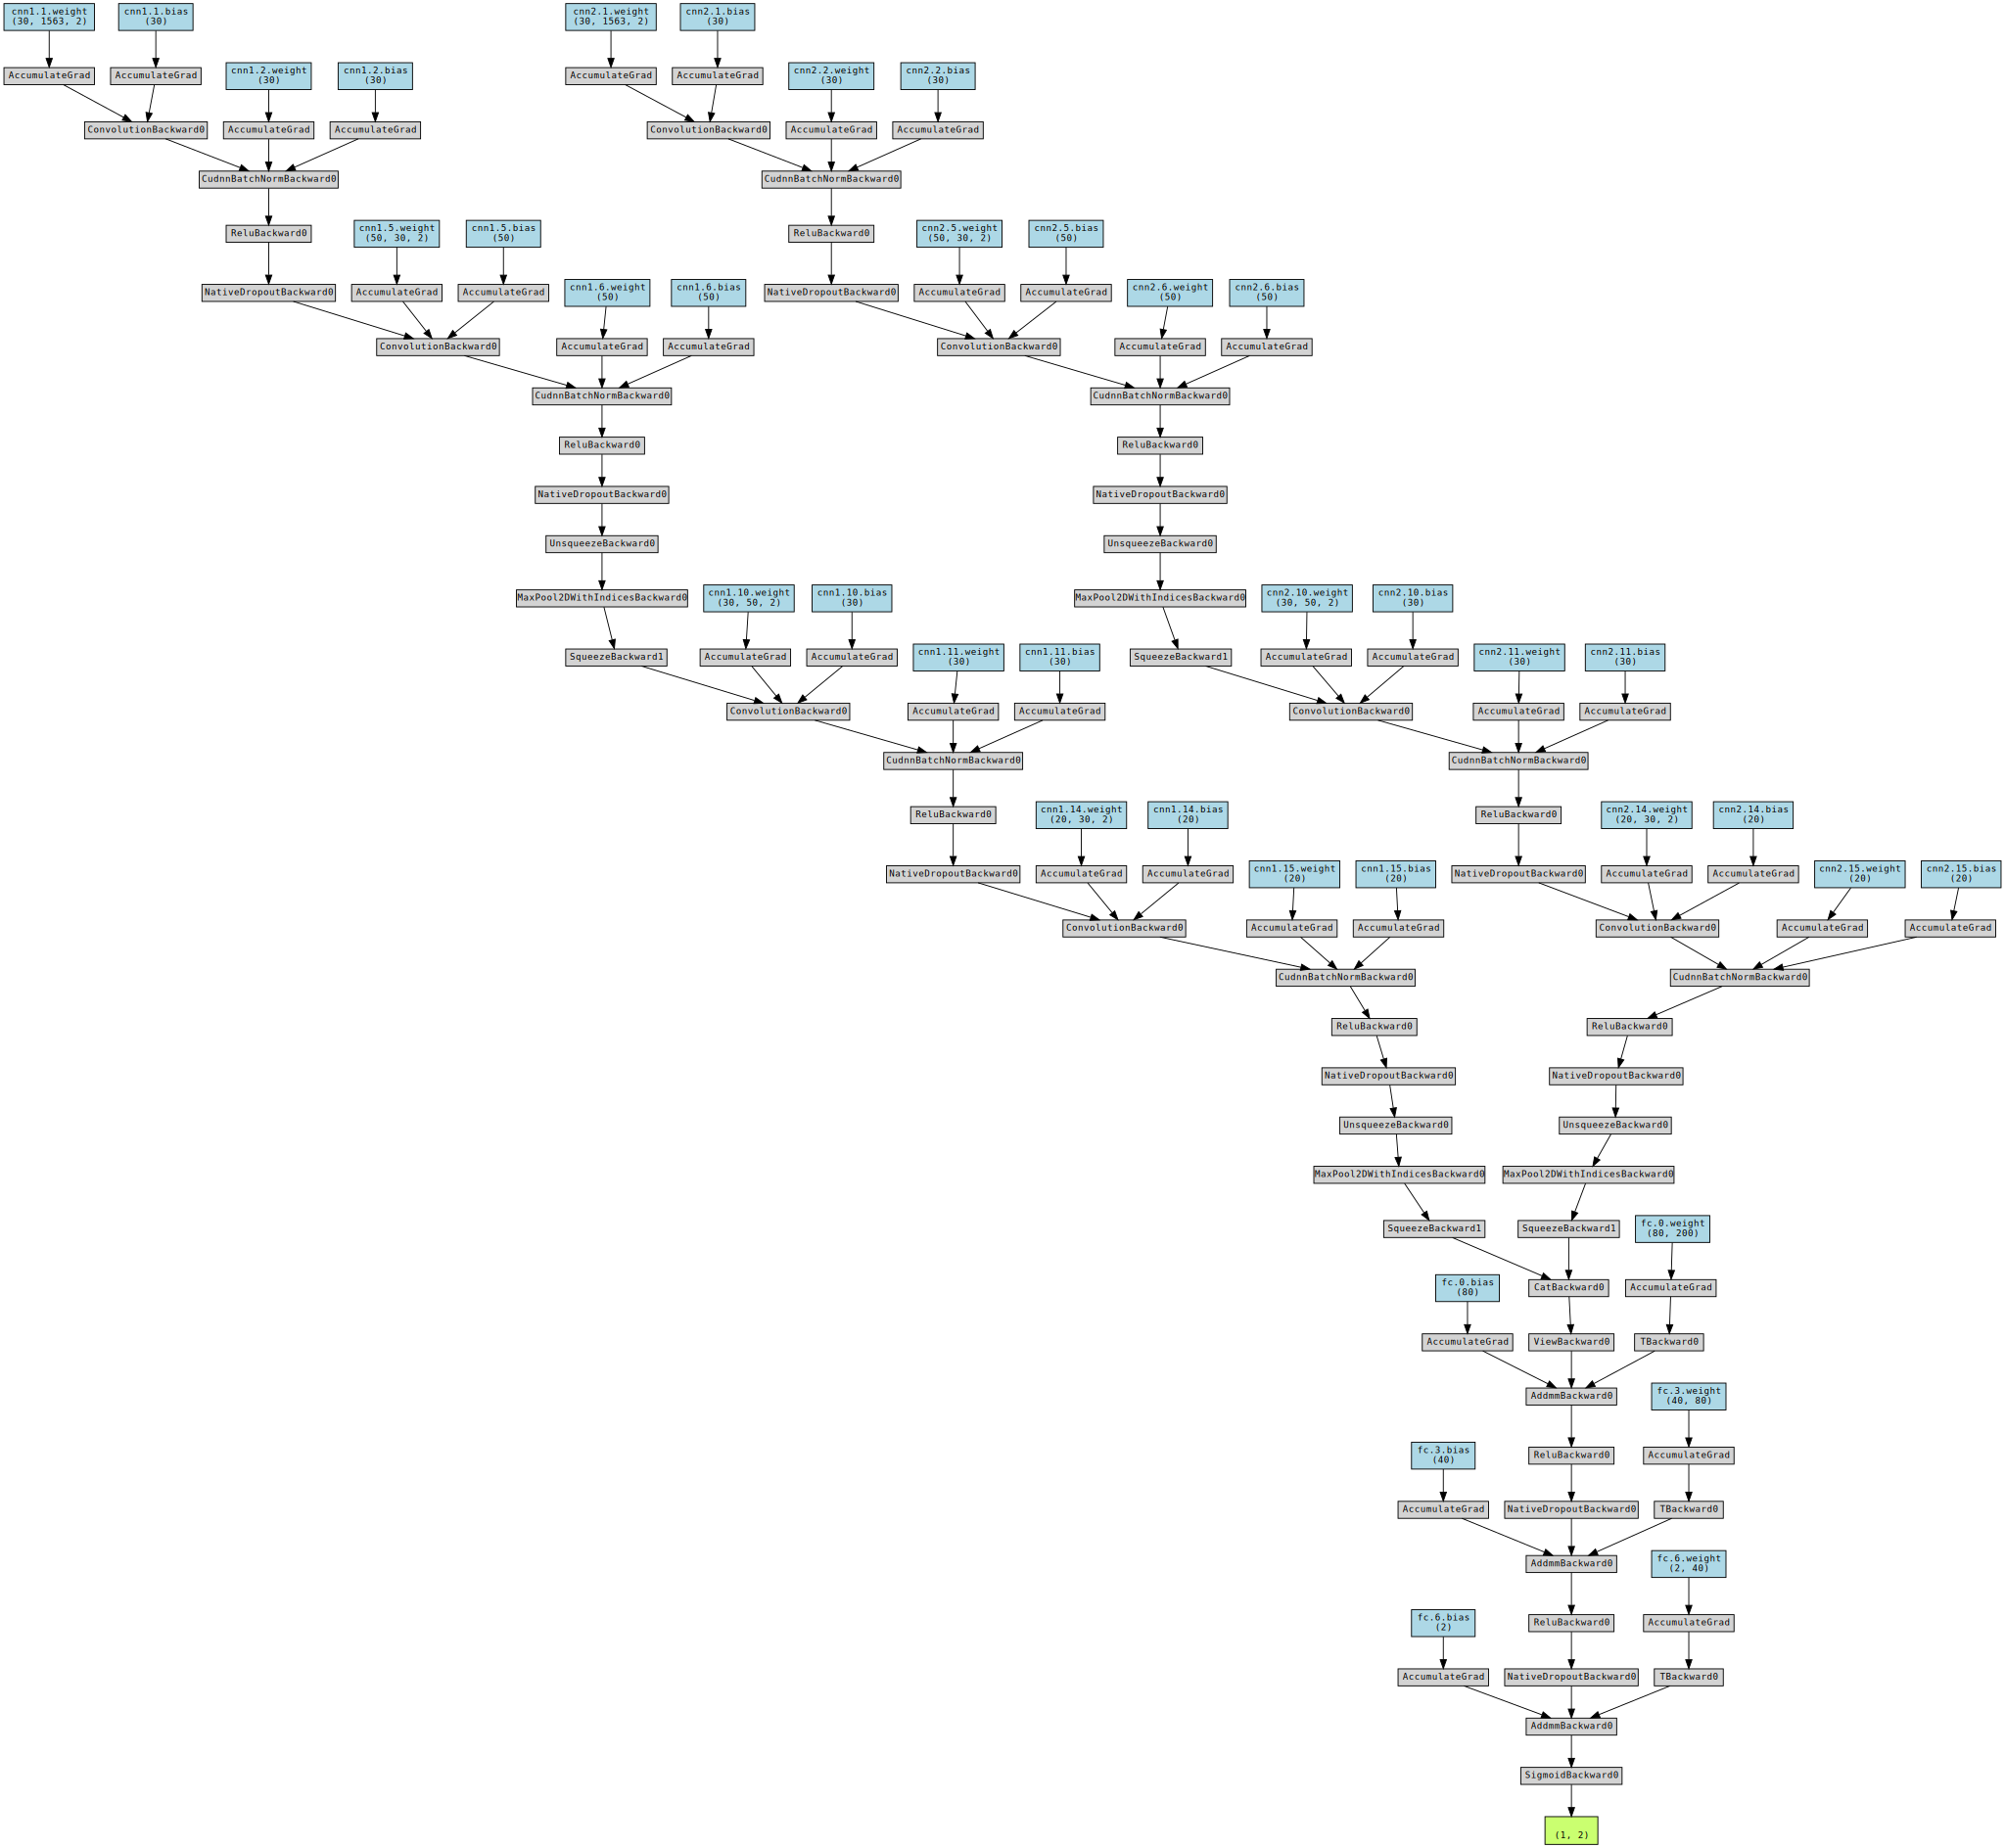

In [17]:
from torchviz import make_dot

rand_seq = torch.randint(0, 25, (1, length), dtype=int).to(device)
y = model(rand_seq, rand_seq)
make_dot(y, params=dict(model.named_parameters()))

Now you can see the graph of the whole module with all the weights and biases
and where they kick in. Due to the size of the network, this is a huge graph.
You can right click to open the image in a new tab to view the full-size svg.

Fairly simple, right? In fact, with such a simple set up, we can already achieve
98%+ accuracy. In the next chapter, I will show how I trained this network in
the [next post](/posts/protein_protein_interaction_p3/).